# Plant Seed V1

## Imports

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
#torch.cuda.set_device

## Data Directory + Create Validation Set 

In [7]:
competition = 'plant-seedlings-classification'

In [20]:
PATH = "data/"+competition+'/'
sz=224
arch=resnet50
#arch=resnext101_64

bs=28
#bs=58

In [10]:
!ls -ltr $PATH | wc -l


       4


In [59]:
from glob2 import glob
from shutil import move
import os 

df = pd.DataFrame(columns=["file", "species"])

for image in glob(PATH+"train/**/*.png"):
    dir_ = image.split('/')
    file_, species = dir_[-1], dir_[-2]

    df = df.append({
        "file": file_,
        "species": species
        }, ignore_index=True)
    move(PATH+"train/"+species+"/"+file_, PATH+"train/")

df.to_csv(PATH+'labels.csv', index=False)



In [82]:
species = df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)
for sp in species.index: 
    os.rmdir(PATH+'train/'+sp)

In [119]:
sample_train = df.sample(100)
sample_train.to_csv(PATH+'sample_labels.csv', index=False)

In [26]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [120]:
sample_train = df.sample(100)
sample_train.to_csv(PATH+'sample_labels.csv', index=False)
sample_label_csv = f'{PATH}sample_labels.csv'
sample_n = len(list(open(sample_label_csv)))-1
sample_val_idxs = get_cv_idxs(sample_n)

In [27]:
label_csv

'data/plant-seedlings-classification/labels.csv'

In [28]:
??get_cv_idxs

In [29]:
n

4750

In [124]:
sample_val_idxs

array([83, 53, 70, 45, 44, 39, 22, 80, 10,  0, 18, 30, 73, 33, 90,  4, 76, 77, 12, 31])

In [83]:
#val_idxs

In [84]:
len(val_idxs)

950

# Initial Exploration

In [33]:
!ls {PATH}

labels.csv            test
sample_submission.csv train


In [34]:
sample_sub = pd.read_csv(f'{PATH}/sample_submission.csv')

In [35]:
sample_sub.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


In [36]:
label_df = pd.read_csv(label_csv)

In [41]:
label_df.head()

label_df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

,file
species,
Loose Silky-bent,654
Common Chickweed,611
Scentless Mayweed,516
Small-flowered Cranesbill,496
Fat Hen,475
Charlock,390
Sugar beet,385
Cleavers,287
Black-grass,263


# Algorithm 

## Enable Data Augmentation/Filtering

In [25]:
??label_df.pivot_table

In [47]:
??tfms_from_model

In [46]:
??Normalize

In [48]:
??image_gen

In [61]:
??ImageClassifierData

In [129]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}/labels.csv', test_name='test', val_idxs=sample_val_idxs, 
                                    tfms=tfms, bs=bs)
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
#learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [130]:
data.trn_ds

In [131]:
len(data.trn_ds), len(data.test_ds)

(80, 794)

In [132]:
len(data.classes), data.classes[:5]

(19, ['Black-grass', 'Charlock', 'Chickweed', 'Cleavers', 'Common'])

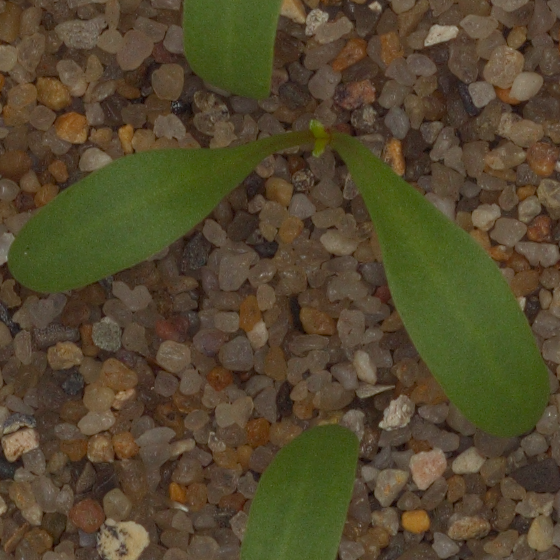

In [133]:
fn = PATH+data.trn_ds.fnames[0]; fn

img = PIL.Image.open(fn); img

In [134]:
img.size

(560, 560)

In [135]:
size_d = {k:PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [136]:
size_d

{'train/00acffa82.png': (560, 560),
 'train/00ba5f88a.png': (83, 83),
 'train/0537577cd.png': (818, 818),
 'train/06bbb09fb.png': (188, 188),
 'train/07ac7bc07.png': (315, 315),
 'train/096eb593d.png': (91, 91),
 'train/09d0908b0.png': (376, 376),
 'train/0b3167af8.png': (856, 856),
 'train/0d5b79c3c.png': (73, 73),
 'train/228d8ad5c.png': (641, 641),
 'train/23775190c.png': (97, 97),
 'train/2424bfd5a.png': (437, 437),
 'train/2424d70aa.png': (405, 405),
 'train/271f14517.png': (95, 95),
 'train/33c1f167f.png': (300, 300),
 'train/34f210a03.png': (465, 465),
 'train/39d5d935a.png': (267, 267),
 'train/412966c74.png': (360, 360),
 'train/430ef0660.png': (96, 96),
 'train/43a753822.png': (151, 151),
 'train/4408bae35.png': (839, 839),
 'train/4b8daeba3.png': (905, 905),
 'train/4c0447f59.png': (186, 186),
 'train/4e2f543a2.png': (135, 135),
 'train/52e82d773.png': (868, 868),
 'train/53c6c6221.png': (652, 652),
 'train/59b1f956d.png': (104, 104),
 'train/59cb79559.png': (145, 145),
 'tr

In [137]:
row_sz, col_sz = zip(*size_d.values())

In [138]:
row_sz=np.array(row_sz); col_sz= np.array(col_sz)

In [139]:
row_sz[:5]

array([560,  83, 818, 188, 315])

(array([ 36.,   8.,  13.,   6.,  10.,   0.,   5.,   0.,   1.,   1.]),
 array([   66. ,   190.5,   315. ,   439.5,   564. ,   688.5,   813. ,   937.5,  1062. ,  1186.5,  1311. ]),
 <a list of 10 Patch objects>)

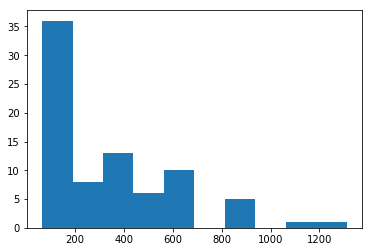

In [140]:
plt.hist(row_sz)

In [141]:
len(row_sz[row_sz<500])

59

(array([ 28.,  11.,   6.,   6.,   8.,   5.,   6.,   3.,   1.,   4.]),
 array([  66. ,  149.9,  233.8,  317.7,  401.6,  485.5,  569.4,  653.3,  737.2,  821.1,  905. ]),
 <a list of 10 Patch objects>)

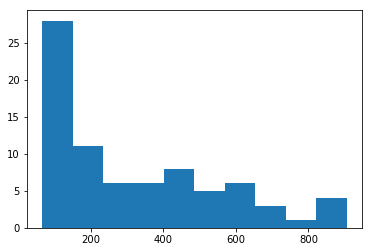

In [142]:
plt.hist(row_sz[row_sz<1000])

(array([ 36.,   8.,  13.,   6.,  10.,   0.,   5.,   0.,   1.,   1.]),
 array([   66. ,   190.5,   315. ,   439.5,   564. ,   688.5,   813. ,   937.5,  1062. ,  1186.5,  1311. ]),
 <a list of 10 Patch objects>)

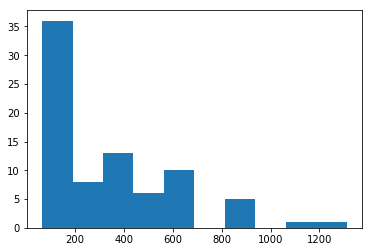

In [143]:
plt.hist(row_sz)

(array([ 36.,   8.,  13.,   6.,  10.,   0.,   5.,   0.,   1.,   1.]),
 array([   66. ,   190.5,   315. ,   439.5,   564. ,   688.5,   813. ,   937.5,  1062. ,  1186.5,  1311. ]),
 <a list of 10 Patch objects>)

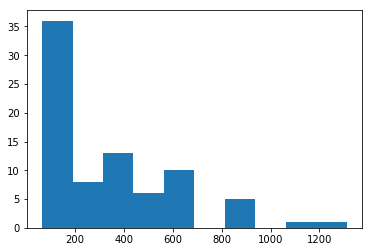

In [144]:
plt.hist(col_sz)

In [145]:
len(col_sz[col_sz<500])

59

(array([ 28.,  11.,   6.,   6.,   8.,   5.,   6.,   3.,   1.,   4.]),
 array([  66. ,  149.9,  233.8,  317.7,  401.6,  485.5,  569.4,  653.3,  737.2,  821.1,  905. ]),
 <a list of 10 Patch objects>)

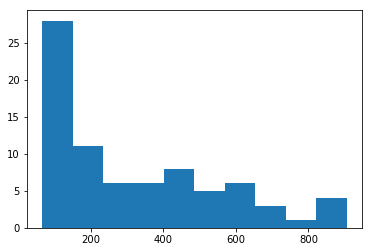

In [146]:
plt.hist(col_sz[col_sz<1000])

In [147]:
len(row_sz[row_sz<500])

59

(array([ 28.,  11.,   6.,   6.,   8.,   5.,   6.,   3.,   1.,   4.]),
 array([  66. ,  149.9,  233.8,  317.7,  401.6,  485.5,  569.4,  653.3,  737.2,  821.1,  905. ]),
 <a list of 10 Patch objects>)

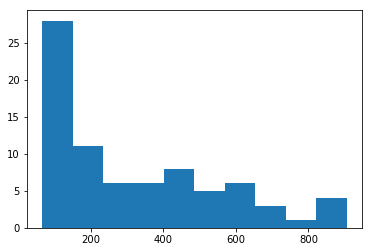

In [148]:
plt.hist(row_sz[row_sz<1000])

## Initial Model 

In [149]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}/labels.csv', test_name='test', val_idxs=val_idxs,
                                    tfms=tfms, bs=bs)
    return data if sz>300  else data.resize(340,'tmp')
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
#learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [153]:
def sample_get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train', f'{PATH}/sample_labels.csv', test_name='test', val_idxs=sample_val_idxs,
                                    tfms=tfms, bs=bs)
    return data if sz>300  else data.resize(340,'tmp')
#data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
#learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

### Precompute

In [154]:
??data.resized

In [157]:
data = get_data(sz,bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2,5)

 62%|██████▏   | 18/29 [02:12<01:21,  7.39s/it]

In [8]:
learn.precompute=False

A Jupyter Widget

[ 0.       0.03025  0.02246  0.99306]                          



In [10]:
learn.fit(1e-2, 5, cycle_len=1)

A Jupyter Widget

[ 0.       0.03622  0.01899  0.99504]                         
[ 1.       0.02817  0.01762  0.99454]                         



In [15]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [17]:
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.03577  0.01557  0.99504]                         
[ 1.       0.03684  0.01287  0.99554]                         
[ 2.       0.02823  0.01572  0.99653]                         



In [114]:
learn.save('224_all_50')

In [115]:
learn.load('224_all_50')

In [131]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

0.901174168297456

In [142]:
log_test_preds = learn.TTA(is_test=True)
#accuracy(log_test_preds,test_y)

In [191]:
len(log_test_preds[1])

10357

In [193]:
log_test_preds[0]

array([[-13.70026, -15.6052 , -16.05228, ..., -16.16833, -14.73604, -13.87907],
       [-12.03872, -17.87734, -16.71374, ..., -18.72832, -16.75751, -16.06612],
       [-18.312  , -10.09572, -13.37985, ..., -14.88402, -18.04798, -12.74705],
       ..., 
       [-15.0935 , -15.21162,  -8.41404, ..., -11.89703, -14.88267, -11.65077],
       [ -8.08542, -13.63547, -14.30865, ..., -14.84465, -14.51801,  -9.85074],
       [-16.39533, -11.34324, -10.12831, ...,  -9.32963, -12.56979, -16.97049]], dtype=float32)

In [196]:
test_probs = np.exp(log_test_preds[0])


In [230]:
out_df_1 = pd.DataFrame(data = test_probs, columns=learn.data.classes)

out_df_1.head()

In [200]:
type(test_probs)

numpy.ndarray

In [194]:
len(data.test_dl.dataset.fnames)

10357

In [205]:
learn.

In [225]:
t = "test/000621fb3cbb32d8935728e48679680e.jpg"
re.match(r".*/(.*)\..*",t)[1]

'000621fb3cbb32d8935728e48679680e'

In [226]:
ids = [re.match(r".*/(.*)\..*",id)[1] for id in data.test_dl.dataset.fnames]

In [201]:
type(data.test_dl.dataset.fnames)

list

In [228]:
out_df = pd.DataFrame({'id':ids})

out_df.head()

In [234]:
result = pd.concat([out_df,out_df_1], axis=1, join_axes=[out_df.index])


result.head()

In [242]:
result.to_csv('dog_breeder_test_submit.1.csv',index=False)


In [243]:
test = pd.read_csv('dog_breeder_test_submit.1.csv')

test.head()

In [211]:
learn.data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [150]:
learn.summary()

AssertionError: Torch not compiled with CUDA enabled

## Analyzing results

In [117]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [133]:
test_preds = np.argmax(log_test_preds, axis=1)
test_probs = np.exp(log_test_preds[:,1])

#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y, preds)


In [139]:
test_probs.shape

(10357,)

In [ ]:
test_labels = []
for i in range(len(test_x)):
    
    test_batch = Variable(test_x[i].unsqueeze_(0))
    
    output = model(test_batch)
    _, output = torch.max(output, dim = 1)
    
    test_labels.append(int(output.data.numpy()))

np.savetxt("foo.csv", test_labels, delimiter=",")

In [134]:
len(test_probs)

10357

[[16  0  0 ...,  0  0  0]
 [ 0 24  0 ...,  0  0  0]
 [ 0  0 15 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 15  0  0]
 [ 0  0  0 ...,  0 22  0]
 [ 0  0  0 ...,  0  0 15]]


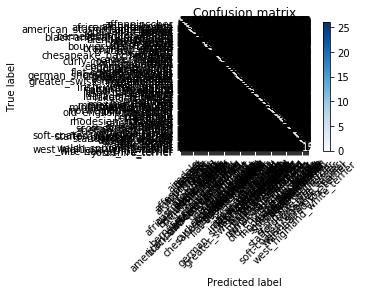

In [118]:
plot_confusion_matrix(cm, data.classes)

In [119]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


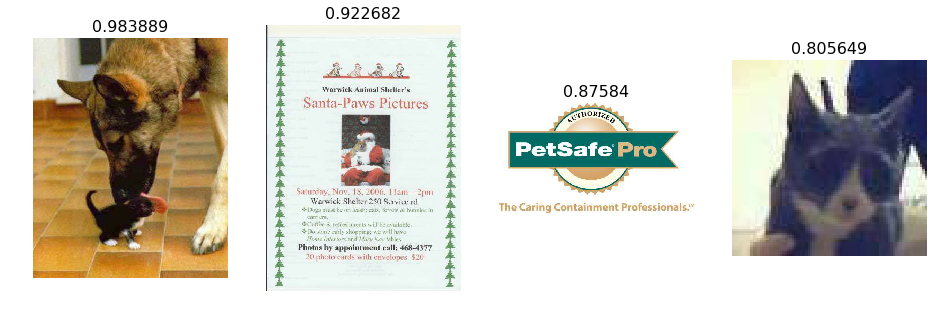

In [28]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


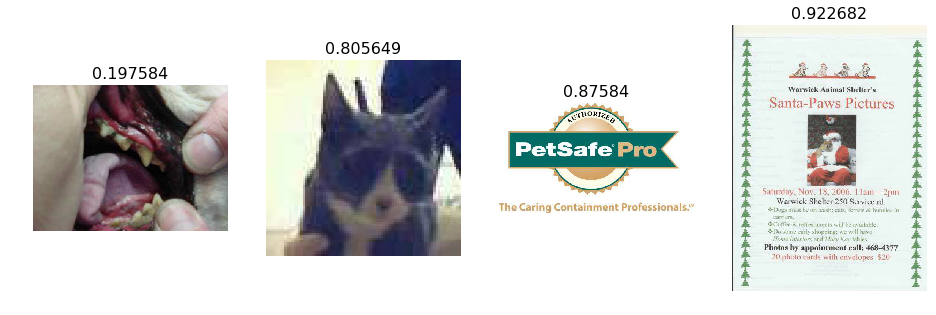

In [29]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")